# The data

The website http://tennis-data.co.uk/alldata.php gathers outcomes of both WTA (Women Tennis Association) and ATP (Association of Tennis Professionals - men only) tennis games over several years.

A short description of each variable can be found here :
http://www.tennis-data.co.uk/notes.txt

In [ ]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile

# Utils
import math

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from glob import glob
logging.getLogger().setLevel('INFO')

# Machin learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Helpers

In [ ]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset
Executing the cell below should provide you with :
- one pandas dataframe for all ATP matches ( df_atp )
- one pandas dataframe for all WTA matches ( df_wta )

In [ ]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

In [ ]:
df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  
INFO:root:52298 matches ATP in df_atp
INFO:root:29581 matches WTA in df_wta


In [ ]:
data_copy = df_atp

In [ ]:
df_atp = data_copy

## Data visualisation and minor correction

Before doing any computation with the data, we want to visualize the dataframe and see if any mistakes or issues occured during the conversion from xls file to dataframe.

In [ ]:
df_atp.describe()

,ATP,Best of,W1,L1,W4,L4,W5,L5,Wsets,CBW,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,52298.000000,52298.000000,52035.000000,52037.000000,4731.000000,4731.000000,1791.000000,1791.000000,52074.000000,17506.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,22745.000000,22745.000000,22745.000000,22745.000000
mean,33.222532,3.372366,5.794331,4.056229,5.777003,3.863454,6.637633,3.756002,2.141760,1.812080,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,8.326076,1.834821,3.594448
std,18.115493,0.778516,1.239577,1.845206,1.274712,1.895683,2.290596,2.817183,0.460311,0.868254,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.628982,397.235666,1.107884,3.282610
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,6.000000,3.000000,6.000000,2.000000,6.000000,2.000000,2.000000,1.280000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.290000,1.850000,1.240000,1.740000
50%,33.000000,3.000000,6.000000,4.000000,6.000000,4.000000,6.000000,3.000000,2.000000,1.550000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.570000,2.780000,1.500000,2.550000
75%,49.000000,3.000000,6.000000,6.000000,6.000000,6.000000,7.000000,5.000000,2.000000,2.050000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.200000,4.540000,2.060000,3.990000
max,69.000000,5.000000,7.000000,7.000000,7.000000,7.000000,70.000000,68.000000,3.000000,14.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


This simple check shows two things :
* Some data types seem to be causing issues, and
* Some columns seem to be missing some data.

These are both potential issues for the modeling phase, so we need to verify this.

In [ ]:
df_atp.dtypes

ATP                    int64
Location              object
Tournament            object
Date          datetime64[ns]
Series                object
Court                 object
Surface               object
Round                 object
Best of                int64
Winner                object
Loser                 object
WRank                 object
LRank                 object
W1                   float64
L1                   float64
W2                    object
L2                    object
W3                    object
L3                    object
W4                   float64
L4                   float64
W5                   float64
L5                   float64
Wsets                float64
Lsets                 object
Comment               object
CBW                  float64
CBL                  float64
GBW                  float64
GBL                  float64
IWW                  float64
IWL                  float64
SBW                  float64
SBL                  float64
B365W         

Our assumption was right. We can begin by casting all columns that should be floats into floats.

In [ ]:
# Looping for all the sets
for i in range(1, 6):
    # Converting void value into nan float
    df_atp.loc[df_atp[f'L{i}'] == ' ', f'L{i}'] = float('nan')
    df_atp.loc[df_atp[f'W{i}'] == ' ', f'W{i}'] = float('nan')

    # Converting object type to float
    df_atp[f'L{i}'] = df_atp[f'L{i}'].astype(float)
    df_atp[f'W{i}'] = df_atp[f'W{i}'].astype(float)

# Converting object that should be float into float
df_atp['Wsets'] = df_atp['Wsets'].astype(float)
df_atp['Lsets'] = pd.DataFrame(pd.to_numeric(df_atp['Lsets'], errors='coerce'))['Lsets']
df_atp['WRank'] = pd.DataFrame(pd.to_numeric(df_atp['WRank'], errors='coerce'))['WRank']
df_atp['LRank'] = pd.DataFrame(pd.to_numeric(df_atp['LRank'], errors='coerce'))['LRank']


We should now be able to start computations with the data.

However, let's check one more time.

In [ ]:
df_atp.describe()

,ATP,Best of,WRank,LRank,W1,L1,W2,L2,W3,L3,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,52298.000000,52298.000000,52282.000000,52193.000000,52035.000000,52037.000000,51524.000000,51525.000000,24070.000000,24070.000000,...,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,22745.000000,22745.000000,22745.000000,22745.000000
mean,33.222532,3.372366,59.172564,92.227042,5.794331,4.056229,5.772824,3.872664,6.025052,3.607104,...,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,8.326076,1.834821,3.594448
std,18.115493,0.778516,73.614866,116.947845,1.239577,1.845206,1.256545,1.874537,0.932111,1.767365,...,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.628982,397.235666,1.107884,3.282610
min,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,19.000000,3.000000,17.000000,35.000000,6.000000,3.000000,6.000000,2.000000,6.000000,2.000000,...,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.290000,1.850000,1.240000,1.740000
50%,33.000000,3.000000,41.000000,65.000000,6.000000,4.000000,6.000000,4.000000,6.000000,4.000000,...,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.570000,2.780000,1.500000,2.550000
75%,49.000000,3.000000,77.000000,105.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,...,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.200000,4.540000,2.060000,3.990000
max,69.000000,5.000000,1890.000000,2159.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000


# Question 1 - 2 points
Who are the three ATP players with the most wins ?

Federer R.         1121
Nadal R.            891
Djokovic N.         802
Ferrer D.           691
Murray A.           624
                   ... 
Rieschick S.          1
Hernych J.            1
Matsukevitch D.       1
Tobon M.              1
Kontinen H.           1
Name: Winner, Length: 948, dtype: int64


Text(0.5, 1.0, 'Number of win by player')

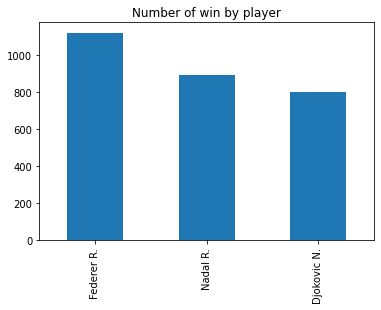

In [ ]:
# Computing results :
winner_count = df_atp["Winner"].value_counts()


# Printing results :
print(winner_count)


# Plotting a happy little graph :
winner_count[:3].plot.bar()
plt.title('Number of win by player')

As we can see, the three ATP players with the most wins are :
- `Federer R.` with `1121` wins
- `Nadal R.` with `891` wins
- `Djokovic N.` with `802` wins

# Question 2 - 2 points
How many sets did the player “ Federer R.” win in total ?

In [ ]:
# Constants :
player_name = 'Federer R.'


# Returns the number of sets won by a given player
def setsWonByPlayer(dataset, player_name):
    """Returns the number of sets won by a given player"""
    
    set_won_win = dataset[(dataset['Winner'] == player_name)]['Wsets'].sum()
    set_won_los = dataset[(dataset['Loser'] == player_name)]['Lsets'].sum()
            
    return set_won_win + set_won_los



# Computing results :
total_sets = setsWonByPlayer(df_atp, player_name)



# Printing results :
print(f'Total sets won : {total_sets}')

Total sets won : 2695.0


Roger Federer has won `2695 sets` between `2000` and `2019`.

# Question 3 - 2 points
How many sets did the player “ Federer R.” win during the years 2016 and 2017 ?

In [ ]:
# Constants :
player_name = 'Federer R.'
df_atp_2016 = df_atp[df_atp['Date'].between('2016-1-1','2016-12-31')]
df_atp_2017 = df_atp[df_atp['Date'].between('2017-1-1','2017-12-31')]


# Computing results :
sets_2016 = setsWonByPlayer(df_atp_2016, player_name)
sets_2017 = setsWonByPlayer(df_atp_2017, player_name)


# Printing results :
print(f'Sets won in 2016: {sets_2016}.')
print(f'Sets won in 2017: {sets_2017}.')
print(f'Total over 2016 and 2017: {sets_2016 + sets_2017}')

Sets won in 2016: 58.0.
Sets won in 2017: 124.0.
Total over 2016 and 2017: 182.0


Roger Federer won :
* `58 sets` in `2016`, which is not really surprising because he had a knee injury and 2016 and couldn't play for a substantial part of the year.
* `124 sets` in `2017`, which is also consistent with his career (1100+ matches won over 20 years, with 2 or 3 sets per match)

# Question 4 - 2 points
For each match, what is the percentage of victories of the winner in the past ?

In [ ]:
def getWinRate(current, player):
    """Function to compute the win rate for current match"""

    # get dataframe for the period before the current match
    prev_matches = df_atp[(df_atp['Date'] < current['Date'])]

    # get all match won
    won_matches = prev_matches[(current[player] == prev_matches['Winner'])]

    if len(won_matches) == 0:
        return 0.0
    else:
        loss_matches = prev_matches[(current[player] == prev_matches['Loser'])]
        return len(won_matches) / (len(won_matches) + len(loss_matches))


In [ ]:
def getWinRateWinner(current):
    return getWinRate(current, 'Winner')

def getWinRateLoser(current):
    return getWinRate(current, 'Loser')

df_atp['Winner_Winrate'] = df_atp.apply(getWinRateWinner, axis=1)
df_atp['Loser_Winrate'] = df_atp.apply(getWinRateLoser, axis=1)

In [ ]:
df_atp[['Winner', 'Winner_Winrate', 'Loser', 'Loser_Winrate']]

,Winner,Winner_Winrate,Loser,Loser_Winrate
0,Dosedel S.,0.000000,Ljubicic I.,0.000000
1,Enqvist T.,0.000000,Clement A.,0.000000
2,Escude N.,0.000000,Baccanello P.,0.000000
3,Federer R.,0.000000,Knippschild J.,0.000000
4,Fromberg R.,0.000000,Woodbridge T.,0.000000
...,...,...,...,...
52293,Zverev A.,0.664032,Isner J.,0.622705
52294,Djokovic N.,0.829876,Cilic M.,0.652047
52295,Zverev A.,0.665354,Federer R.,0.829142
52296,Djokovic N.,0.830052,Anderson K.,0.589792


# Question 5 - 12 points
Please predict the outcome for each ATP tennis game during the year 2017.
Your notebook should handle:
- the data preparation process
- the modeling phase
- the evaluation of your model(s)
- any observation or explanation you deem interesting

Bonus points if :
- your notebook contains graphics that are both interesting and pretty
- The code is clear and well explained

In [ ]:
data = df_atp[df_atp['Date'].between('2000-1-1','2017-12-31')]

## Preprocessing

Before trying to use machine learning with the dataset, we need to "sanitize" the data.
This will improve our chances of getting meaningful results and of avoiding data leakage.

### Visualizing data before preprocessing

Viszualizing the data before cleaning the dataset will help us find what we need to remove and/or change in the dataframe.

<AxesSubplot:>

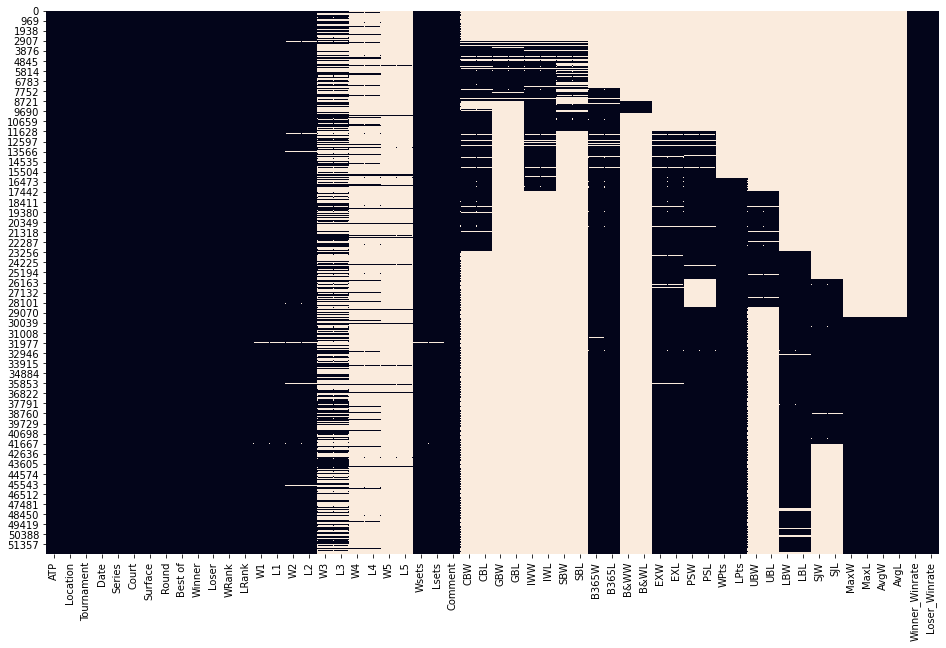

In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap(df_atp.isnull(), cbar=False)

This chart shows all the missing data (in white). We can now define exactly what is missing, and we may choose to change or remove it before feeding it to our model.

### Focusing dataframe 

We want to focus on data directly concerning the matches. Therefore, we will drop all columns related to comments or bets, because they only contain external info - nothing we need right now.

We will also be removing the "after match" data for obvious reasons.
The sets data will also have to go, because the machine would just be able to simply calculate a match's results based on points, which would be data leakage.

We can clearly see on the above heatmap that the player points will become a problem for us. A lot of them are missing, and this is a probleme because it could alter our model's predictions. Therefore, we will also be removing them from the data, because we can't invent them.

In [ ]:
# Dropping unnecessary columns (sets, comments and bets)
data = df_atp
data = data.drop(data.loc[:, 'W1':'AvgL'].columns, axis = 1)

### Cleaning data

Here, we will be removing all unusable data, such as NaN occurrences in the rank columns for example.

In [ ]:
data.isna().sum()

ATP                 0
Location            0
Tournament          0
Date                0
Series              0
Court               0
Surface             0
Round               0
Best of             0
Winner              0
Loser               0
WRank              16
LRank             105
Winner_Winrate      0
Loser_Winrate       0
dtype: int64

In [ ]:
# Dropping matches where the player has no rank
data = data.dropna(subset = ['WRank', 'LRank'])

print(f'After the data cleaning we have lost {df_atp.shape[1] - data.shape[1]} columns out of {df_atp.shape[1]}')
print(f'After the data cleaning we have lost {df_atp.shape[0] - data.shape[0]} rows out of {df_atp.shape[0]}')

After the data cleaning we have lost 41 columns out of 56
After the data cleaning we have lost 121 rows out of 52298


In [ ]:
data.isna().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank             0
LRank             0
Winner_Winrate    0
Loser_Winrate     0
dtype: int64

### Avoiding data leakage



One of the issues which we are concerned about with the data in its current state is data leakage.

In order to avoid it, we have decided to randomly split the set into winners and losers in a new dataframe.
This allows us to remove the machine's capacity to extrapolate a match's result either from the column names or from a player's score.

In [ ]:
import random

for i in data.index:
    if random.randint(0,1) < 0.5:
        data.at[i, 'P1'] = data.at[i, 'Winner']
        data.at[i, 'P2'] = data.at[i, 'Loser']

        # Associate the data to the right player
        data.at[i, 'P1_Rank'] = data.at[i, 'WRank']
        data.at[i, 'P2_Rank'] = data.at[i, 'LRank']
        data.at[i, 'P1_Winrate'] = data.at[i, 'Winner_Winrate']
        data.at[i, 'P2_Winrate'] = data.at[i, 'Loser_Winrate']

        # Adding the result column
        data.at[i, 'P1_is_Winner'] = 1
        
    else:
        data.at[i, 'P1'] = data.at[i, 'Loser']
        data.at[i, 'P2'] = data.at[i, 'Winner']

        # Associate the data to the right player
        data.at[i, 'P1_Rank'] = data.at[i, 'LRank']
        data.at[i, 'P2_Rank'] = data.at[i, 'WRank']
        data.at[i, 'P1_Winrate'] = data.at[i, 'Loser_Winrate']
        data.at[i, 'P2_Winrate'] = data.at[i, 'Winner_Winrate']

        # Adding the result column
        data.at[i, 'P1_is_Winner'] = 0

Now we can drop all the old columns

In [ ]:
features = ['Winner', 'Loser', 'WRank', 'LRank', 'Winner_Winrate', 'Loser_Winrate']
data = data.drop(columns=features)

### Visualizing data after preprocessing

This step allows us to make sure that our preprocessing was efficient and that the data is prepared as intended.

In [ ]:
# Printing the resulting processed dataframe's info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52177 entries, 0 to 52297
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ATP           52177 non-null  int64         
 1   Location      52177 non-null  object        
 2   Tournament    52177 non-null  object        
 3   Date          52177 non-null  datetime64[ns]
 4   Series        52177 non-null  object        
 5   Court         52177 non-null  object        
 6   Surface       52177 non-null  object        
 7   Round         52177 non-null  object        
 8   Best of       52177 non-null  int64         
 9   P1            52177 non-null  object        
 10  P2            52177 non-null  object        
 11  P1_Rank       52177 non-null  float64       
 12  P2_Rank       52177 non-null  float64       
 13  P1_Winrate    52177 non-null  float64       
 14  P2_Winrate    52177 non-null  float64       
 15  P1_is_Winner  52177 non-null  float6

<AxesSubplot:>

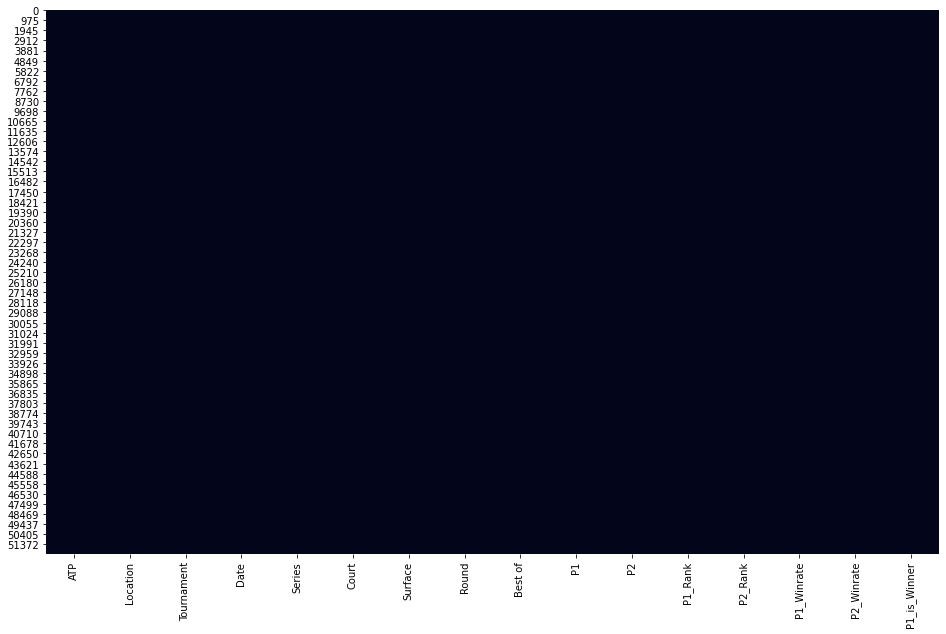

In [ ]:
# Heatmap of the processed dataframe
plt.figure(figsize=(16,10))
sns.heatmap(data.isnull(), cbar=False)

TODO date should be split in float

In [ ]:
for i in data.index:
  data.at[i, 'Year'] = data.at[i, 'Date'].year
  data.at[i, 'Month'] = data.at[i, 'Date'].month
  data.at[i, 'Day_of_month'] = data.at[i, 'Date'].day

data = data.drop(columns=['Date'])

In [ ]:
data.dtypes

ATP               int64
Location         object
Tournament       object
Series           object
Court            object
Surface          object
Round            object
Best of           int64
P1               object
P2               object
P1_Rank         float64
P2_Rank         float64
P1_Winrate      float64
P2_Winrate      float64
P1_is_Winner    float64
Year            float64
Month           float64
Day_of_month    float64
dtype: object

**Much better**

ready for modeling

## Data modeling

### Splitting the training data and testing data

TODO: dis qqchose sur le spliting

TODO: la on definit les col tukone

In [ ]:
# Preparing columns as inputs
cols_encoded = ['P1', 'P2', 'Location', 'Series', 'Court', 'Surface', 'Round', 'Year', 'Month', 'Day_of_month']
cols_raw = ['P1_Rank', 'P2_Rank', 'P1_Winrate', 'P2_Winrate', 'Best of']
cols_used = cols_encoded + cols_raw

# Preparing columns for output
cols_expected = ['P1_is_Winner', 'Year'] # Year is only for spliting purposes

la on va utilise des dumies values pour etre plus fast dans le rendering des model

In [ ]:
x = pd.get_dummies(data[cols_used])
y = pd.get_dummies(data[cols_expected])

apres bah on split normal, la suite logique

In [ ]:
x_before_2017 = x[x['Year'] < 2017]
y_before_2017 = y[y['Year'] < 2017]
y_before_2017 = y_before_2017.drop(columns=['Year']) # removing the year from the expected columns

X_train, x_test, Y_train, y_test = train_test_split(x_before_2017, y_before_2017, train_size=0.6)

### Preparing model testing function

In [ ]:
def try_model(model):
    """
    Function to train a model and return accuracy
    """

    # training model
    model.fit(X_train, Y_train)

    # testing on training data
    Y_train_prediction = model.predict(X_train)

    # computing accuracy
    train_score = accuracy_score(Y_train, Y_train_prediction)

    if train_score <= 0.5:
        print(f"Model perform worst than random on training with a score of: {accuracy}")
    else:
        print(f"Model perform better than random on training with a score of: {accuracy}")
        # testing on test data
        y_test_prediction = model.predict(x_test)

        # computing final accuracy
        test_score = accuracy_score(y_test, y_test_prediction)

        print(f"The model final score is: {test_score}")


## Testing different models

### K Nearest Neighbors

TODO: on utilise ça pk ? et pk en regressor ?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier()
try_model(KNN_model)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KernelInterrupted: Execution interrupted by the Jupyter kernel.

### Decision Tree Classifier

TODO: pk encore

In [1]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
try_model(dt_model)

NameError: name 'try_model' is not defined

### Random Forest

TODO: skuuuuuu (il est tard de ouf)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
try_model(rfc)

## Observation

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7b7403a0-e6a1-4dff-9c60-92b666e62671' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>